In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

## Load the data

In [2]:
df = pd.read_csv('../cleaned_data/FREN.csv', index_col='Date', parse_dates=True)
df.head()

,7 DAYS MA,14 DAYS MA,21 DAYS MA,7 DAYS STD DEV,RSI 7,RSI 14,RSI 21,MFI 7,MFI 14,MFI 21,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Close
Date,,,,,,,,,,,,,,,,,,
2012-10-17,-0.077792,-0.039585,-0.041007,-0.484714,2.223844,2.575815,2.574613,1.633924,1.679844,1.552717,0.008923,1.34241,1.016593,-1.845348,1.033444,0.147246,1.030312,0.440118
2012-10-18,-0.003835,-0.007674,-0.010651,1.422315,0.937519,1.283190,1.404574,1.679668,1.748685,1.672304,0.716706,1.34241,1.016593,-1.845348,1.042927,0.261864,1.030312,0.201081
2012-10-19,0.038425,0.004293,0.002741,1.517442,1.158441,1.511092,1.626116,0.908951,0.920132,0.908441,1.424489,1.34241,1.016593,-1.845348,1.052410,0.376483,1.030312,0.293018
2012-10-22,0.093893,0.025567,0.019705,1.628038,1.070196,1.424646,1.546813,0.634583,0.627739,0.526947,-1.406643,1.34241,1.016593,-1.845348,1.080859,0.720337,1.096678,0.274631
2012-10-23,0.141436,0.046841,0.028634,1.606590,0.794613,1.164224,1.310060,0.566140,0.561087,0.541269,-0.698860,1.34241,1.016593,-1.845348,1.090342,0.834955,1.096678,0.219468


### Plot the Close price - our target

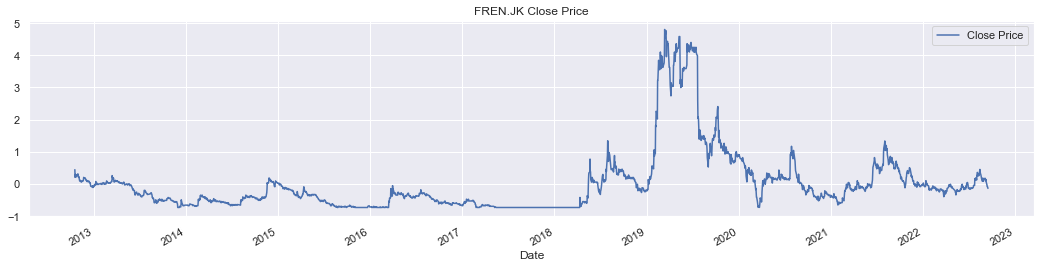

In [3]:
df['Close'].plot(figsize=(18, 4))
plt.legend(['Close Price'])
plt.title('FREN.JK Close Price')
plt.show()

### Split the data
- Split the data into independent variables and target variable
- Split the data into train and test set (80:20)

In [4]:
train_len = int(len(df)*.8)
train_dataset = df[:train_len]
test_dataset = df[train_len:len(df)]

In [5]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Close')
test_labels = test_features.pop('Close')

## Understanding Time Series Data

### Decompose time series into Trend, Seasonality, and Random Noise

In [6]:
import statsmodels.api as sm

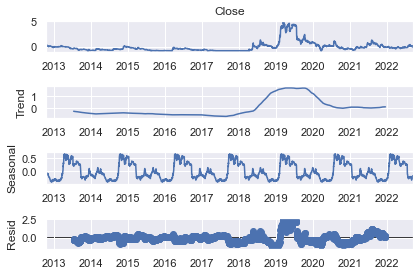

In [7]:
seas_d = sm.tsa.seasonal_decompose(df['Close'], model='additive', period=365)
fig = seas_d.plot()
plt.show()

### ADF Test to check stationarity of the data

In [8]:
from statsmodels.tsa.stattools import adfuller
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [9]:
test_adf(df['Close'], 'Stock Close Price')

Strong evidence for Null Hypothesis
Accept Null Hypothesis - Data is not Stationary
Data is NOT Stationary for Stock Close Price


In [10]:
"""
The Close price is not stationary. 
Therefore, differencing needs to be performed
"""
test_adf(df['Close'].diff(), 'Stock Close Price - First Difference')

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary Stock Close Price - First Difference


### Plot ACF (Autocorrelation) and PACF (Partial Autocorrelation)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


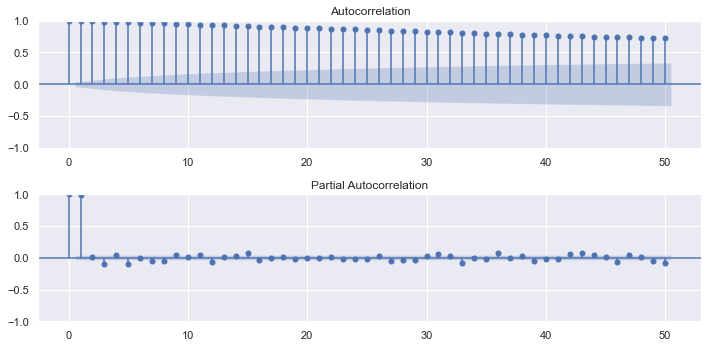

In [11]:
fig, ax = plt.subplots(2,1, figsize=(10,5))

fig = sm.tsa.graphics.plot_acf(df['Close'], lags=50, ax=ax[0])

fig = sm.tsa.graphics.plot_pacf(df['Close'], lags=50, ax=ax[1])
plt.tight_layout()
plt.show()

## Build the SARIMAX model

### Use auto_arima to determine the optimal p,d,q orders
We can determine p,d,q orders by using ACF and PACF plots above. However, a stepwise search will enable us to try out more optimal p,d,q orders.

In [12]:
from pmdarima.arima import auto_arima

In [13]:
step_wise_exog = auto_arima(train_labels, exogenous= train_features,
                           start_p=1, start_q=1, 
                           max_p=7, max_q=7, 
                           d=None, D=1, test='adf', max_d=7, seasonal=True, m=5,
                           trace=True, 
                           error_action='ignore', 
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[5] intercept   : AIC=inf, Time=3.58 sec
 ARIMA(0,0,0)(0,1,0)[5] intercept   : AIC=-86.232, Time=0.32 sec
 ARIMA(1,0,0)(1,1,0)[5] intercept   : AIC=-2657.593, Time=1.43 sec
 ARIMA(0,0,1)(0,1,1)[5] intercept   : AIC=-1199.123, Time=1.00 sec
 ARIMA(0,0,0)(0,1,0)[5]             : AIC=-88.213, Time=0.17 sec
 ARIMA(1,0,0)(0,1,0)[5] intercept   : AIC=-2220.760, Time=0.30 sec
 ARIMA(1,0,0)(2,1,0)[5] intercept   : AIC=-2910.712, Time=2.01 sec
 ARIMA(1,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=6.50 sec
 ARIMA(1,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=4.36 sec
 ARIMA(0,0,0)(2,1,0)[5] intercept   : AIC=-119.517, Time=0.71 sec
 ARIMA(2,0,0)(2,1,0)[5] intercept   : AIC=-2909.646, Time=3.41 sec
 ARIMA(1,0,1)(2,1,0)[5] intercept   : AIC=-2909.440, Time=2.66 sec
 ARIMA(0,0,1)(2,1,0)[5] intercept   : AIC=-1197.226, Time=1.53 sec
 ARIMA(2,0,1)(2,1,0)[5] intercept   : AIC=-2924.573, Time=5.62 sec
 ARIMA(2,0,1)(1,1,0)[5] intercept   : AIC=

In [14]:
step_wise_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1967
Model:             SARIMAX(3, 0, 2)x(0, 1, [1], 5)   Log Likelihood                1676.582
Date:                             Wed, 23 Nov 2022   AIC                          -3337.163
Time:                                     00:27:38   BIC                          -3292.509
Sample:                                          0   HQIC                         -3320.751
                                            - 1967                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.586e-05      0.000     -0.121      0.904      -0.000       0.000
ar.L1          0.9727      0.131      7.447      0.000       0.717       1.229
ar.L2          0.3099      0.149      2.073      0.038       0.017       0.603
ar.L3         -0.2926      0.087     -3.377      0.001      -0.462      -0.123
ma.L1         -0.0165      0.133     -0.124      0.901      -0.278       0.244
ma.L2         -0.2040      0.089     -2.294      0.022      -0.378      -0.030
ma.S.L5       -0.9422      0.008   -123.586      0.000      -0.957      -0.927
sigma2         0.0105   8.14e-05    129.492      0.000       0.010       0.011
===================================================================================
Ljung-Box (L1) (Q):                   1.69   Jarque-Bera (JB):            175720.90
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):              22.06   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        49.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

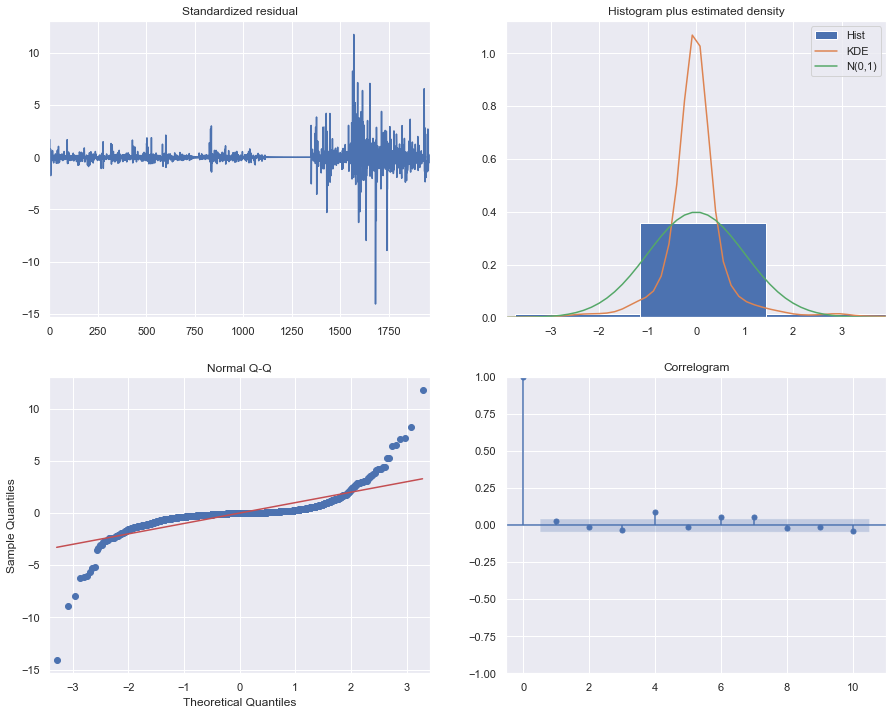

In [15]:
step_wise_exog.plot_diagnostics(figsize=(15,12));

### Fit the SARIMAX model using the best p,d,q orders

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [18]:
model_exog = SARIMAX(train_labels, exog=train_features,
                order=(3,0,2), seasonal_order=(0,1,1,5),
                enforce_invertibility=True, enforce_stationarity=True)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [19]:
results = model_exog.fit()

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Close   No. Observations:                 1967
Model:             SARIMAX(3, 0, 2)x(0, 1, [1], 5)   Log Likelihood                2125.690
Date:                             Wed, 23 Nov 2022   AIC                          -4203.381
Time:                                     00:29:07   BIC                          -4069.419
Sample:                                          0   HQIC                         -4154.145
                                            - 1967                                         
Covariance Type:                               opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
7 DAYS MA          0.7891      0.070     11.230      0.000       0.651       0.927
14 DAYS MA         0.1097      0.134      0.822      0.411      -0.152       0.371
21 DAYS MA         0.0753      0.091      0.824      0.410      -0.104       0.254
7 DAYS STD DEV    -0.0230      0.002     -9.789      0.000      -0.028      -0.018
RSI 7             -0.0889      0.010     -8.498      0.000      -0.109      -0.068
RSI 14             0.4143      0.020     20.669      0.000       0.375       0.454
RSI 21            -0.1593      0.014    -11.671      0.000      -0.186      -0.133
MFI 7             -0.0040      0.007     -0.549      0.583      -0.018       0.010
MFI 14            -0.0147      0.011     -1.303      0.192      -0.037       0.007
MFI 21            -0.0288      0.009     -3.199      0.001      -0.046      -0.011
dayofweek       3.173e-05      0.002      0.017      0.987      -0.004       0.004
quarter           -0.0480      0.023     -2.105      0.035      -0.093      -0.003
month              0.0767      0.807      0.095      0.924      -1.505       1.659
year              -0.0304      0.103     -0.296      0.768      -0.232       0.171
dayofyear         -0.0364      0.821     -0.044      0.965      -1.645       1.572
dayofmonth         0.0027      0.069      0.039      0.969      -0.132       0.137
weekofyear         0.0016      0.035      0.045      0.964      -0.066       0.070
ar.L1              1.5407      0.098     15.755      0.000       1.349       1.732
ar.L2             -0.3199      0.178     -1.800      0.072      -0.668       0.029
ar.L3             -0.2796      0.085     -3.290      0.001      -0.446      -0.113
ma.L1             -0.6104      0.097     -6.280      0.000      -0.801      -0.420
ma.L2             -0.1363      0.087     -1.561      0.118      -0.307       0.035
ma.S.L5           -0.9356      0.007   -129.199      0.000      -0.950      -0.921
sigma2             0.0067   8.76e-05     76.807      0.000       0.007       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):            137149.41
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               9.36   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        43.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predictions

In [21]:
predictions = results.predict(start=train_len, end=len(df)-1, exog=test_features)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [22]:
actual_close = df[['Close']]
act = pd.DataFrame(actual_close.iloc[train_len:, 0])

In [23]:
predictions = pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index = test_features.index
predictions['Actual'] = act['Close']
predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)

In [24]:
predictions

,Pred,Actual
Date,,
2020-09-10,-0.117205,-0.160836
2020-09-11,-0.163269,-0.179296
2020-09-14,-0.111679,-0.050079
2020-09-15,-0.133497,-0.086998
2020-09-16,-0.153321,-0.105458
...,...,...
2022-09-12,0.009732,-0.031620
2022-09-13,-0.054707,-0.086998
2022-09-14,-0.075667,-0.086998


<AxesSubplot:xlabel='Date'>

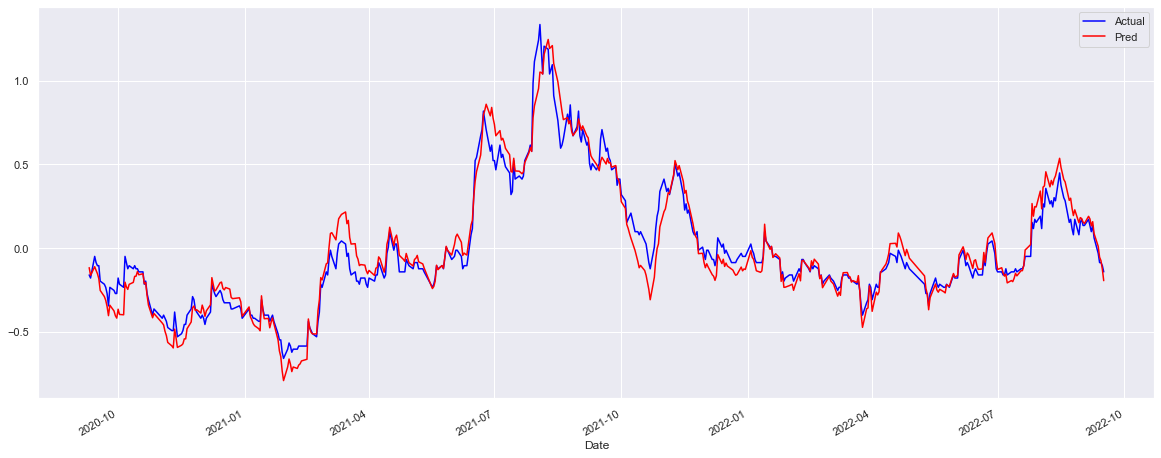

In [25]:
predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))

### Evaluation

In [26]:
from joblib import load

In [27]:
close_scaler = load('../feature_engineering/fren_close_scaler.bin')

In [28]:
inversed_pred = close_scaler.inverse_transform(np.array(predictions['Pred']).reshape(-1,1))
inversed_act = close_scaler.inverse_transform(np.array(predictions['Actual']).reshape(-1,1))

In [29]:
inversed = pd.DataFrame(inversed_pred)
inversed['Actual'] = inversed_act
inversed.rename({0:'Pred'}, axis=1, inplace=True)
inversed.index = test_labels.index
inversed.head(2)

,Pred,Actual
Date,,
2020-09-10,83.363619,81.0
2020-09-11,80.868202,80.0


**Plot Error Distribution**

In [30]:
def plotErrorHist(inversed_df):
    """
    Function to plot error histogram
    """
    error = inversed_df['Pred'] - inversed_df['Actual']
    plt.hist(error, bins=25)
    plt.xlabel('Prediction Error [Close]')
    _ = plt.ylabel('Count')

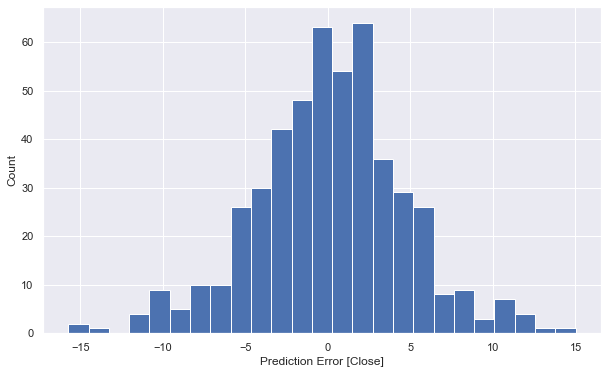

In [31]:
plt.figure(figsize=(10,6))
plotErrorHist(inversed)

**RMSE**

In [32]:
from statsmodels.tools.eval_measures import rmse

In [33]:
rmse(inversed['Pred'], inversed['Actual'])

4.5967057557705955

**MAPE**

In [34]:
# mape
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [35]:
mape(inversed['Actual'], inversed['Pred'])

3.947820420770683

**R-squared**

In [36]:
from sklearn.metrics import r2_score

In [37]:
r2_score(inversed['Actual'], inversed['Pred'])

0.9423980408046835

### Save the model

In [38]:
from joblib import dump, load
dump(results, './models/fren.joblib') 

['./models/fren.joblib']

In [39]:
loaded = load('./models/fren.joblib')
loaded.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Close   No. Observations:                 1967
Model:             SARIMAX(3, 0, 2)x(0, 1, [1], 5)   Log Likelihood                2125.690
Date:                             Wed, 23 Nov 2022   AIC                          -4203.381
Time:                                     00:30:10   BIC                          -4069.419
Sample:                                          0   HQIC                         -4154.145
                                            - 1967                                         
Covariance Type:                               opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
7 DAYS MA          0.7891      0.070     11.230      0.000       0.651       0.927
14 DAYS MA         0.1097      0.134      0.822      0.411      -0.152       0.371
21 DAYS MA         0.0753      0.091      0.824      0.410      -0.104       0.254
7 DAYS STD DEV    -0.0230      0.002     -9.789      0.000      -0.028      -0.018
RSI 7             -0.0889      0.010     -8.498      0.000      -0.109      -0.068
RSI 14             0.4143      0.020     20.669      0.000       0.375       0.454
RSI 21            -0.1593      0.014    -11.671      0.000      -0.186      -0.133
MFI 7             -0.0040      0.007     -0.549      0.583      -0.018       0.010
MFI 14            -0.0147      0.011     -1.303      0.192      -0.037       0.007
MFI 21            -0.0288      0.009     -3.199      0.001      -0.046      -0.011
dayofweek       3.173e-05      0.002      0.017      0.987      -0.004       0.004
quarter           -0.0480      0.023     -2.105      0.035      -0.093      -0.003
month              0.0767      0.807      0.095      0.924      -1.505       1.659
year              -0.0304      0.103     -0.296      0.768      -0.232       0.171
dayofyear         -0.0364      0.821     -0.044      0.965      -1.645       1.572
dayofmonth         0.0027      0.069      0.039      0.969      -0.132       0.137
weekofyear         0.0016      0.035      0.045      0.964      -0.066       0.070
ar.L1              1.5407      0.098     15.755      0.000       1.349       1.732
ar.L2             -0.3199      0.178     -1.800      0.072      -0.668       0.029
ar.L3             -0.2796      0.085     -3.290      0.001      -0.446      -0.113
ma.L1             -0.6104      0.097     -6.280      0.000      -0.801      -0.420
ma.L2             -0.1363      0.087     -1.561      0.118      -0.307       0.035
ma.S.L5           -0.9356      0.007   -129.199      0.000      -0.950      -0.921
sigma2             0.0067   8.76e-05     76.807      0.000       0.007       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):            137149.41
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               9.36   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        43.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""